Text(0, 0.5, 'y')

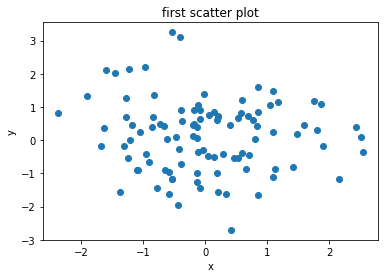

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
# generate data
x = np.random.randn(100)
y = np.random.randn(100)

fig = plt.figure()

ax = fig.add_subplot(1,1,1)

ax.scatter(x,y)

ax.set_title('first scatter plot')
ax.set_xlabel('x')
ax.set_ylabel('y')

#fig.show()

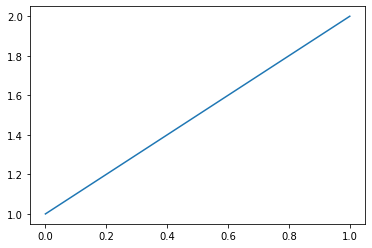

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.plot((1,2))
plt.show()

In [2]:
import math
import torch
class torch_KMeans:
    def init_centroids_pp(self,n_cluster: int,data: torch.Tensor) -> torch.Tensor:
        """
        n_cluster : int (n)
        data : (N,E)
        return -> (n,E)
        """
        datalen = data.size(0)
        assert n_cluster <= datalen

        centroids = torch.zeros(n_cluster+1,data.size(1),dtype=data.dtype).to(data.device)
        _first = torch.randint(0,datalen,(1,))[0]
        centroids[0] = data[_first]
        dist = torch.sum((data-data[_first].repeat(datalen,1))**2,dim=1)
        _second = torch.multinomial(dist,1)[0]
        centroids[1] = data[_second]

        for i in range(2,n_cluster):
            centroids = self.pp_next_centroids(centroids,data,now_len=i)
        return centroids[:n_cluster]

    def pp_next_centroids(self,centroids:torch.Tensor, data:torch.Tensor,now_len=None) -> torch.Tensor:
        """
        centroids : (n,E)
        data : (N,E)
        return -> if now_len is None, (n+1,E), else (n,E)
        """
        assert centroids.size(0) < data.size(0) and centroids.size(1) == data.size(1)
        ellen = data.size(1)
        if now_len is None:
            now_len = centroids.size(0)
            _c = torch.zeros(now_len+1,centroids.size(1)).to(centroids.device)
            _c[:now_len] = centroids
            centroids = _c

        datalen = data.size(0)

        cl,dist = self.clustering(centroids[:now_len],data,return_distances=True)
        idxes = torch.arange(datalen)
        keep_points = torch.zeros(now_len,ellen,dtype=centroids.dtype)
        keep_sumdis = torch.zeros(now_len,dtype=centroids.dtype)
#        print(now_len)
        for t in range(now_len):
            b = cl==t
            use = dist[t][b]
            idx = idxes[b]
            if use.size(0) == 1 and use[0] == 0.0:
                keep_sumdis[t] = math.inf
                continue
#            try:
            use_idx = torch.multinomial(use,1)[0]
#            except:
#                print(use)
#                fig = plt.figure()
#                ax = fig.add_subplot(1,1,1)
#                x,y = zip(*centroids[:now_len].numpy())
#                ax.scatter(x,y)
#                raise Exception('Error')
            using_data = data[idx[use_idx]]
            centroids[now_len] = using_data
            keep_points[t] = using_data
            _cl,_dist = self.clustering(centroids[:now_len+1],data,return_distances=True)
            _gokei = torch.zeros(_dist.size(0))
            for d in range(_dist.size(0)):
                _gokei[d] = torch.sum(_dist[d][_cl==d])
            keep_sumdis[t] = torch.sum(_gokei)

        centroids[now_len] = keep_points[torch.argmin(keep_sumdis)]
        return centroids

        
    
    def get_next_centroid(self,n_cluster: int, data: torch.Tensor,cluster_list: torch.Tensor) -> torch.Tensor:
        """
        n_cluster : n
        data : (N,E)
        cluster_list : (N,)
        return : (n,E)
        """
        assert data.size(0) == cluster_list.size(0)
        next_c = torch.zeros(n_cluster,data.size(1)).to(data.device)
        for i in torch.unique(cluster_list):
            placevec = data[cluster_list == i]
            next_c[i] = torch.sum(placevec,dim=0) / placevec.size(0)
        del data,placevec,cluster_list
        return next_c
    
    def clustering(self,centroids: torch.Tensor,data: torch.Tensor,return_distances= False):
        """
        data : (N,E)
        centoroids : (C,E) <- C <= N
        return : [0,1,3,1 ....] <- torch.tensor
        """

        datalen = data.size(0)
        centlen = centroids.size(0)
        assert centlen <= datalen and data.size(1) == centroids.size(1)
        
        cluster = torch.zeros(datalen).type(torch.int32).to(data.device)
        distances = [torch.sum((data-i.repeat(datalen,1))**2,dim=1) for i in centroids]
        distances = torch.stack(distances)
        for t,i in enumerate(distances):
            _d = i.repeat(centlen,1)
            b = _d <= distances
            boolean = torch.prod(b,dim=0).type(torch.bool)
            cluster[boolean] = t
        del datalen,centlen,boolean,_d
        if return_distances:
            return cluster,distances
        else:
            del distances
            return cluster

In [3]:
"""writing utf-8"""
import torch
import os 
import random
import math

class torch_KMeans:

    def KMeans(self,n_cluster:int, data:torch.Tensor, max_iter=300,centroids_init='k-means++',seed=0) -> torch.Tensor:
        """
        n_cluster : n
        data : (N,E)
        max_iter : default 300
        centroids_init : default k-means++, another option is random
        """
        assert n_cluster <= data.size(0)
        self.reset_seed(seed)
        device = data.device
        if centroids_init == 'k-means++':
            centroids = self.init_centroids_pp(n_cluster,data)
        else:
            datamax = torch.max(torch.abs(data))
            centroids = torch.randn(n_cluster,data.size(1)).to(device)
            _cmax = torch.max(torch.abs(centroids))
            centroids /= datamax / _cmax  

        for _ in range(n_cluster):
            classes = self.clustering(centroids,data)
            _cent = self.get_next_centroid(n_cluster,data,classes)
            if torch.sum(centroids-_cent) != 0:
                centroids = _cent
            else:
                break
        return centroids



    def init_centroids_pp(self,n_cluster: int,data: torch.Tensor) -> torch.Tensor:
        """
        n_cluster : int (n)
        data : (N,E)
        return -> (n,E)
        """
        datalen = data.size(0)
        assert n_cluster <= datalen

        centroids = torch.zeros(n_cluster+1,data.size(1),dtype=data.dtype).to(data.device)
        _first = torch.randint(0,datalen,(1,))[0]
        centroids[0] = data[_first]
        dist = torch.sum((data-data[_first].repeat(datalen,1))**2,dim=1)
        _second = torch.multinomial(dist,1)[0]
        centroids[1] = data[_second]

        for i in range(2,n_cluster):
            centroids = self.pp_next_centroids(centroids,data,now_len=i)
        return centroids[:n_cluster]

    def pp_next_centroids(self,centroids:torch.Tensor, data:torch.Tensor,now_len=None) -> torch.Tensor:
        """
        centroids : (n,E)
        data : (N,E)
        return -> if now_len is None, (n+1,E), else (n,E)
        """
        assert centroids.size(0) < data.size(0) and centroids.size(1) == data.size(1)
        ellen = data.size(1)
        if now_len is None:
            now_len = centroids.size(0)
            _c = torch.zeros(now_len+1,centroids.size(1)).to(centroids.device)
            _c[:now_len] = centroids
            centroids = _c

        datalen = data.size(0)

        cl,dist = self.clustering(centroids[:now_len],data,return_distances=True)
        idxes = torch.arange(datalen)
        keep_points = torch.zeros(now_len,ellen,dtype=centroids.dtype)
        keep_sumdis = torch.zeros(now_len,dtype=centroids.dtype)
        for t in range(now_len):
            b = cl==t
            use = dist[t][b]
            idx = idxes[b]
            if use.size(0) == 1 and use[0] == 0.0:
                keep_sumdis[t] = math.inf
                continue
            use_idx = torch.multinomial(use,1)[0]
            using_data = data[idx[use_idx]]
            centroids[now_len] = using_data
            keep_points[t] = using_data
            _cl,_dist = self.clustering(centroids[:now_len+1],data,return_distances=True)
            _gokei = torch.zeros(_dist.size(0))
            for d in range(_dist.size(0)):
                _gokei[d] = torch.sum(_dist[d][_cl==d])
            keep_sumdis[t] = torch.sum(_gokei)

        centroids[now_len] = keep_points[torch.argmin(keep_sumdis)]
        return centroids

    def get_next_centroid(self,n_cluster: int, data: torch.Tensor,cluster_list: torch.Tensor) -> torch.Tensor:
        """
        n_cluster : n
        data : (N,E)
        cluster_list : (N,)
        return : (n,E)
        """
        assert data.size(0) == cluster_list.size(0)
        next_c = torch.zeros(n_cluster,data.size(1)).to(data.device)
        for i in torch.unique(cluster_list):
            placevec = data[cluster_list == i]
            next_c[i] = torch.sum(placevec,dim=0) / placevec.size(0)
        del data,placevec,cluster_list
        return next_c
            
            


    def clustering(self,centroids: torch.Tensor,data: torch.Tensor,return_distances= False):
        """
        data : (N,E)
        centoroids : (C,E) <- C <= N
        return : [0,1,3,1 ....] <- torch.tensor
        """

        datalen = data.size(0)
        centlen = centroids.size(0)
        assert centlen <= datalen and data.size(1) == centroids.size(1)
        
        cluster = torch.zeros(datalen).type(torch.int32).to(data.device)
        distances = [torch.sum((data-i.repeat(datalen,1))**2,dim=1) for i in centroids]
        distances = torch.stack(distances)
        for t,i in enumerate(distances):
            _d = i.repeat(centlen,1)
            b = _d <= distances
            boolean = torch.prod(b,dim=0).type(torch.bool)
            cluster[boolean] = t
        del datalen,centlen,boolean,_d
        if return_distances:
            return cluster,distances
        else:
            del distances
            return cluster

    def reset_seed(self,seed=0):
        os.environ['PYTHONHASHSEED'] = '0'
        random.seed(seed)
        torch.manual_seed(seed)

In [19]:
dumd1 = torch.randn(25,2) + 5
dumd2 = torch.randn(25,2) -5
dumd3 = torch.randn(25,2) * 5
dumd4 = torch.randn(25,2) * -5
dumd = torch.cat([dumd1,dumd2,dumd3,dumd4])

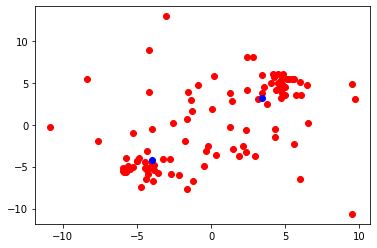

In [22]:
#dumd = torch.randn(100,2)
KMeans = torch_KMeans()
centroids = KMeans.KMeans(2,dumd,30)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
x,y = zip(*dumd.numpy())
ax.scatter(x,y,color='red')
x,y = zip(*centroids.numpy())
ax.scatter(x,y,color='blue')

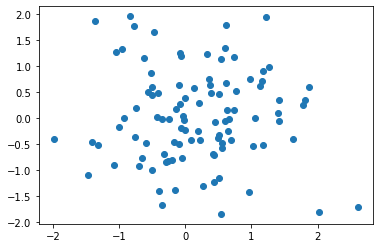

In [6]:
#dumd = torch.randn(100,2)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
x,y = zip(*dumd.numpy())
ax.scatter(x,y)

In [7]:
KMeans = torch_KMeans()
#dumc = torch.randn(3,2)
dumc = KMeans.init_centroids_pp(3,dumd)
dumd = torch.randn(100,2)
cl = KMeans.clustering(dumc,dumd)
c = dumc.detach().numpy()
d = dumd.detach().numpy()
cln = cl.detach().numpy()
cent = KMeans.get_next_centroid(3,dumd,cl)
centn= cent.detach().numpy()
cen = KMeans.init_centroids_pp(3,dumd)

Text(0, 0.5, 'y')

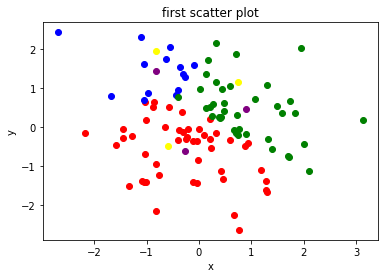

In [8]:
data = (d[cln==0], d[cln==1], d[cln==2])
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
for t,i in enumerate(['red','blue','green']):
    x,y = zip(*data[t])
    ax.scatter(x,y,color=i)
x,y = zip(*c)
ax.scatter(x,y,color='yellow')
x,y = zip(*centn)
ax.scatter(x,y,color='purple')
#x,y = zip(*cen)
#ax.scatter(x,y,color='brown')
ax.set_title('first scatter plot')
ax.set_xlabel('x')
ax.set_ylabel('y')

Text(0, 0.5, 'y')

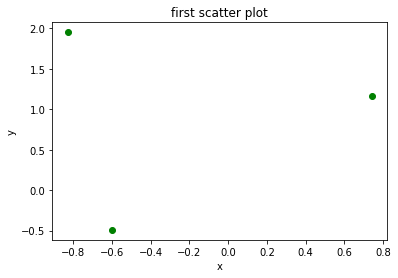

In [9]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
data = np.random.randn(10,2)
x, y = zip(*c)
ax.scatter(x,y,color='green')
x, y = zip(*d)

ax.set_title('first scatter plot')
ax.set_xlabel('x')
ax.set_ylabel('y')
#ax.plot(np.random.randn(10,2),color='red',marker='x',linewidth=0)